In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
from itertools import combinations
from matplotlib.lines import Line2D
import networkx as nx
from IPython.display import Image
import collections
from operator import attrgetter


#set random seed
np.random.seed(300)

# load wheel point cloud
wheel = np.genfromtxt('data/wheel.txt', delimiter=' ')

# select random indicies from the point cloud
random_indices = np.random.choice(wheel.shape[0], 200)

# subset the point cloud
subcloud = wheel[random_indices, ]

# create toy figure eight example
points = np.array([[-1, 4], [2, 4], [-3, 2], [3, 2], [-2, 0],
                   [2,0], [-3, -2], [3, -2], [-2, -4], [1, -4]])

## Part 6. HoPeS : a Homologically Persistent Skeleton

Before introducing a new skeleton based on persistence, let us show how to quickly compute the 1D persistence of $\alpha$-complexes of a 2D point cloud.

### 6.1. Graphs dual to alpha-complexes in the plane

The general algorithm for computing persistence in dimension $>0$ (on any filtration of complexes) has a cubic worst-case complexity in the number of simplices (vertices + edges + triangles etc) and is based on linear algebra (a reduction of matrices to normal forms). 

However, for a 2D cloud $C$ of $n$ points in the plane, the 1D persistence can be computed in time $O(n\log n)$ due to the following relation between $\alpha$-complexes and their dual graphs $C^*(\alpha)$.

For any complex $C(\alpha)\subset{\mathbb R}^2$, let us represent each triangle in the complement $Del(C)-C(\alpha)$ by a vertex of the <i>dual graph</i> $C^*(\alpha)$. On extra vertex will represent the unbounded component of ${\mathbb R}^2-Del(C)$. Two vertices are connected by an edge in the dual graph $C^*(\alpha)$ if the corresponding triangles share a common edge outside $C(\alpha)$.

The duality between embedded complexes $C(\alpha)\subset{\mathbb R}^2$ and abstract graphs $C^*(\alpha)$ means that there is a 1-1 correspondence between holes (including the unbounded one) in $C(\alpha)$ and connected components of the dual graph $C^*(\alpha)$.

The code below outputs the dual graph for the full Delaunay triangulation Del$(C)$ when $C$ is a 10-point cloud and a larger sample from the wheel graph.

In [25]:
def draw_dual_graph(tri):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    alpha = 0.3
    
    # plot the Delauney triangulation
    ax.triplot(tri.points[:,0],
               tri.points[:,1],
               tri.simplices.copy(),
               c='orange',
               alpha=alpha)
    
    # get the centre for each face to act as a vertex in the dual graph
    faces = np.array([tri.points[s].mean(axis=0) for s in tri.simplices])
    ax.scatter(faces[:,0],
               faces[:,1],c='r')
    
    # get all edges on the boundry of the triangulation
    hashable = map(frozenset, tri.convex_hull)
    outer_edges = set(hashable)
    edges = set([])
    
    
    # draw an edge on the axis
    def add_line(u, v, style ='-'):
        l = Line2D([u[0], v[0]], [u[1], v[1]], ls=style,
                   c='black', linewidth=1)
        ax.add_line(l)
    
    # for each neighboour of each face in the Delauney triangulation
    for i, neighbours in enumerate(tri.neighbors):
        for neighbour in neighbours:
            
            u, v = sorted([i, neighbour])
            # if the face neighbours the infinite face, approximate a point for the dual graph edge
            if neighbour == -1:
                
                # find out which edges of the triangle are boundry edges
                combs = [frozenset(c) for c in combinations(tri.simplices[i], 2)]
                intersection = outer_edges.intersection(combs)
                # for each outer edge in the triangulation draw on outwards pointing edge
                # in the delauney triangulation graph
                for (p1, p2) in intersection:
                    
                    distX = (tri.points[p1][0] - tri.points[p2][0]) / 2
                    distY = (tri.points[p1][1] - tri.points[p2][1]) / 2
                    midX = (tri.points[p1][0] - distX)
                    midY = (tri.points[p1][1] - distY)
                    edges.add((v, midX*2, midY*2))
                    add_line(faces[v],(midX*2, midY*2), '--')
                    
            # if the neighbour is finite draw an edge between 
            # the verticies that represent the triangles       
            else:
                add_line(faces[u], faces[v])
                
    # assert than the right number of outer edges was processed
    assert len(edges) == len(outer_edges)

    ax.set_aspect('equal')
    return plt.show()

In [26]:
draw_dual_graph(Delaunay(points))

In [4]:
draw_dual_graph(Delaunay(subcloud))

### 6.2. Computing 1D persistence for 2D complexes

The above duality between holes in embedded complexes $C(\alpha)\subset{\mathbb R}^2$ and connected components of the graphs $C^*(\alpha)$ extends to their persistence as follows.

<b>Duality lemma</b>. The life span $[birth,death)$ of any 1D cycle in the ascending filtration of complexes $C(\alpha)$ corresponds to the life span $(birth,death]$ of a connected component in the descending filtration of the dual graphs $C^*(\alpha)$.

When $\alpha$ decreases and we remove a <i>critical</i> edge $e$ from a complex $C(\alpha)$, this corresponds to the birth moment of a cycle, which persists in $C(\alpha)$ for scales $\alpha'>\alpha$, but not below $\alpha$. At the same time, the removal of the edge $e$ from $C(\alpha)$ means that two components (representing two holes separated by $e$ in ${\mathbb R}^2$) merge into a larger component in the dual graph $C^*(\alpha)$.   

The algorithm below maintains the connectivity of $C^*(\alpha)$ when the scale $\alpha$ decreases and outputs dots (birth,death) for the 1D persistence of the filtration of $C(\alpha)$.

In [27]:
# u, v denote triangles that share this edge
# w = length of the edge in the Delaunay triangulation
# p1,p2 are the vertices connected by the edge
Edge = collections.namedtuple('Edge', 'u v w p1 p2')
CriticalEdge = collections.namedtuple('CriticalEdge', 'birth death p1 p2')

In [28]:

def getRadius(points):
    
    epsilon = 10e-8
    
    # get the lengths of the sides of the triangle and sort them
    p1 = points[0]
    p2 = points[1]
    p3 = points[2]
    a = distance.euclidean(p1, p3)
    b = distance.euclidean(p2, p3)
    c = distance.euclidean(p1, p2)
    
    var1,var2,largest = sorted([a, b, c])
    
    # if the triangle is right angled or obtuse return 0
    if abs((largest) ** 2-((var1 ** 2 + (var2) ** 2))) < epsilon:
        return 0
    elif (largest) ** 2 > ((var1 ** 2 + (var2) ** 2)):
        return 0
    
    # otherwise return its circumradius
    radius = (a*b*c)/ math.sqrt((a+b+c)*(a+b-c)*(a+c-b)*(c+b-a))
    
    return radius

In [29]:
def setup_dual_graph(tri):
    
    edges = []
    traversed_edges = set([])
    alphas = []
    hashable = map(frozenset, tri.convex_hull)
    outer_edges = set(hashable)
    max_death = 0
    
    # create an edge e in the dual graph edge and add e to the list
    # if e is not yet there
    def add_edge(u,v,p1,p2):
        if frozenset((p1,p2)) not in traversed_edges:
            w = distance.euclidean(tri.points[p1],
                                   tri.points[p2])
            edges.append(Edge(u,v,w,p1,p2))
            traversed_edges.add(frozenset((p1, p2)))
    
    # for every simplex
    for i, (simplex, neighbours) in enumerate(zip(tri.simplices, tri.neighbors)):
        
        s = set(simplex)
        # record the birthtime of a cycle if the triangle is acute 
        radius = getRadius(tri.points[simplex])
        alphas.append(radius)

        if radius > max_death:
            max_death = radius

        # add an edge from this face to every neighbour,
        # where the length of the edge is equal to the
        # length of the edge the two faces share
        for neighbour in neighbours:
            
            u, v = sorted([i, neighbour])
            
            # infinite case: find the edges that is on the convex hull
            if neighbour == -1:
                u = len(tri.simplices)
                combs = [frozenset(c) for c in combinations(simplex, 2)]
                intersection = outer_edges.intersection(combs)
                for (p1, p2) in intersection:
                    add_edge(u,v,p1,p2)
                    
            # finite case: find the common edge
            else: 
                n = set(tri.simplices[neighbour])
                p1, p2 = s.intersection(n)
                add_edge(u,v,p1,p2)

    alphas.append(max_death)
    return edges, alphas

In [31]:
def HoPeS(pointcloud):
    
    tri = Delaunay(pointcloud)
    critical_edges = []
    edges, alphas = setup_dual_graph(tri)
    L = 0 #keep track of the added links of the dual graph
    mst = []
    # at the beginning every node is its own parent
    parents = [i for i in range(len(tri.simplices))]
    parents.append(len(parents))
    # sort the edges in the descending order
    edges.sort(key=attrgetter('w'), reverse=True)
    
    def parent(i):
        # quickly go up along parent links to the root
        while parents[i] != i:
            i = parents[i]
        return i
    
    # remove edges in the descending order
    for i, edge in enumerate(edges):
        
        # get the current value of alpha where two open balls intersect
        alpha = edge.w / 2.0
        # get the roots and death/birth times in the dual graph
        root_u, root_v = parent(edge.u), parent(edge.v)
        alpha_u, alpha_v = alphas[root_u], alphas[root_v]

        # case 1 - two white faces
        # (the two faces already belong to the same component)
        if (root_u == root_v):
            # the edge to the minimum spanning tree
            mst += [edge]
            continue

        # case 2 - one white, one gray face
        # parts of different components
        elif ((alpha_u == 0 and alpha_v > 0) or
              (alpha_v == 0 and alpha_u > 0)):

            # swap the variables for the symmetric case
            if (alpha_u < alpha_v):
                alpha_u, alpha_v = alpha_v, alpha_u
                root_u, root_v = root_v, root_u
            # join trees in the union-find structure
            parents[root_v] = root_u
            alphas[root_v] = alpha_u

        #case 3 - two gray faces
        elif (alpha_u == 0 and alpha_v == 0):
            parents[root_v] = root_u 
            alphas[root_u] = alpha
        
        # case 4 - two white faces
        # death of a cycle
        else:
            
            # swap the variables for the symmetric case
            if (alpha_u < alpha_v):
                alpha_u, alpha_v = alpha_v, alpha_u
                root_u, root_v = root_v, root_u
            # keep the older component
            death = min([alpha_u, alpha_v])
            # record the persistence dot and change the parent
            critical_edges.append(CriticalEdge(alpha, death,
                                               edge.p1, edge.p2))

            parents[root_v] = root_u
        
        L += 1
        if (L >= len(tri.simplices)):
            break
            
    return edges[i+1:] + mst, critical_edges

In [32]:
mst, critical_edges = HoPeS(points)
critical_edges

[CriticalEdge(birth=2.0, death=2.5769410160110375, p1=4, p2=5),
 CriticalEdge(birth=1.5, death=2.5769410160110375, p1=8, p2=9)]

In [33]:
def plot_diagram(dgm, show = False, labels = False):
    """Plot the persistence diagram."""

    inf = float('inf')
    min_birth = min(p.birth for p in dgm if p.birth != inf)
    max_birth = max(p.birth for p in dgm if p.birth != inf)
    min_death = min(p.death for p in dgm if p.death != inf)
    max_death = max(p.death for p in dgm if p.death != inf)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    ax.set_aspect('equal', 'datalim')

    min_diag = min(min_birth, min_death)
    max_diag = max(max_birth, max_death)
    ax.scatter([p.birth for p in dgm], [p.death for p in dgm])
    ax.plot([min_diag, max_diag], [min_diag, max_diag])        # diagonal

    if labels:
        ax.set_xlabel("birth")
        ax.set_ylabel("death")

    return plt.show()

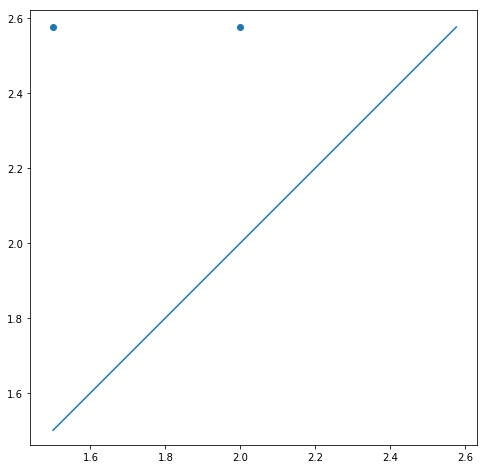

In [34]:
plot_diagram(critical_edges)

### 6.3. HoPeS = MST plus critical edges

The dots in the 1D persistence diagram appear due to the addition/removal of critical edges that close/break a closed cycle bounding a new hole of an alpha-complex.

A critical edge may not be uniquely defined if a point cloud $C$ contains two pairs of points at the same distance from each other, see such an example for the 10-point cloud below.

After the scale $\alpha$ has dropped to a value when all critical edges have been found, $C(\alpha)$ becomes a connected complex without holes. Decreasing $\alpha$ even further will gradually split $C(\alpha)$ into smaller connected components (until we get isolated dots of $C$), which simulatenously produces all edges of a Minimum Spanning Tree of $C$. 

<b>Definition</b>. A <i>Homologically Peristent Skeleton</i> HopeS$(C)$ of a point cloud $C$ is a Minimum Spanning Tree $MST(C)$ plus the critical edges corresponding to all dots in the 1D persistence diagram of a filtration of complexes on $C$.

The above concept was introduced in the <a href="http://kurlin.org/research-papers.php#CGF2015">CGF paper</a> (Computer Graphics Forum, 2015) and makes sense in a much more general case than demonstrated here, namely for any finite metric space $C$ and any filtration of complexes on $C$.

The picture below on the right shows edges of $MST(C)$ in blue and critical edges of $HoPeS(C)$ in red.

In [35]:
Image(filename='data/img/D33_full_HoPeS.png')

In [36]:
def draw_hopes(points, mst, critical_edges):
    
    # create axis
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    ax.scatter(points[:,0],
               points[:,1],c='black')
    
    # draw the mst edges
    for e in mst:
        p1 = points[e.p1]
        p2 = points[e.p2]
        l = Line2D([p1[0], p2[0]], [p1[1], p2[1]], 
                   c='blue', linewidth=0.5)
        ax.add_line(l)
    
    # draw the critical edges
    for ce in critical_edges:
        p1 = points[ce.p1]
        p2 = points[ce.p2]
        l = Line2D([p1[0], p2[0]], [p1[1], p2[1]], 
                   c='r', linewidth=0.5)
        ax.add_line(l)

    ax.axis('equal')
    return plt.show()

The procedure draw_hopes(...) draws a Homologically Persistent Skeleton (HoPeS) for the example clouds below.

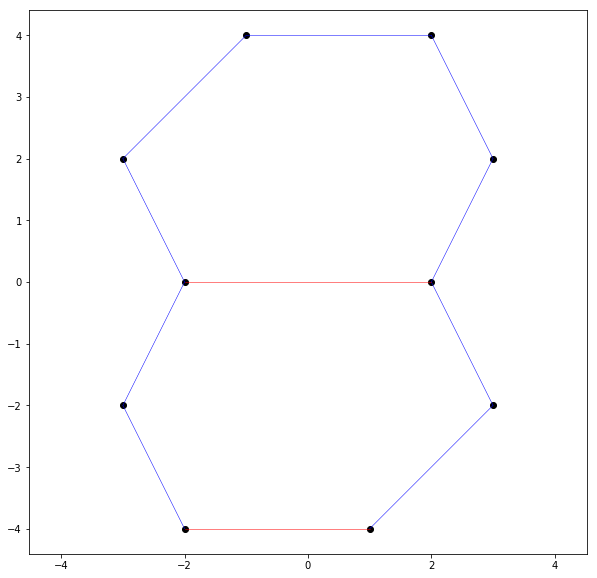

In [37]:
draw_hopes(points, mst, critical_edges)

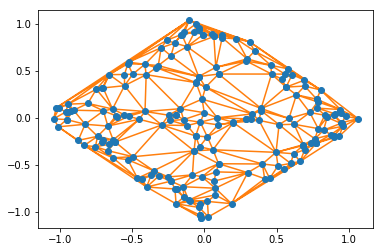

In [15]:
tri = Delaunay(subcloud)
plt.plot(subcloud[:,0], subcloud[:,1], 'o')
plt.triplot(subcloud[:,0], subcloud[:,1], tri.simplices.copy())
plt.show()

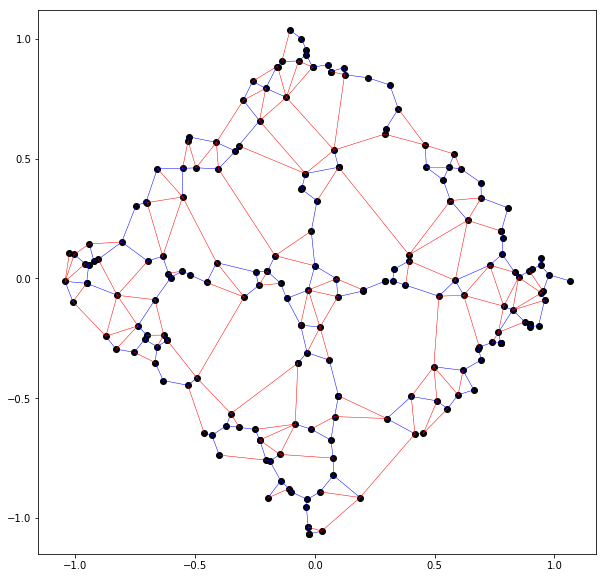

In [38]:
mst, critical_edges = HoPeS(subcloud)
draw_hopes(subcloud, mst, critical_edges)

### 6.4. Reduced HoPeS is optimal across all scales

Similarly to a reduced $MST(C;\alpha)$, which was discussed in part 2, the full Homologically Perisstent Skeleton has a reduced version $HoPeS(C;\alpha)$ at a scale $\alpha$, a subgraph including only critical edges corresponding to dots with birth $\leq\alpha<$ death.

The blue quadrant $[-\infty,\alpha]\times(\alpha,+\infty)$ contains 7 red dots in the pictire below on the left, which correspond to 7 red critical edges in the picture on the right.

In [17]:
Image(filename='data/img/D33_reduced_HoPeS.png')

<b>Optimality Theorem</b>. For any scale $\alpha$, a reduced $HoPeS(C;\alpha)$ has the minimum length among all graphs $G\subset C^{\alpha}$ with the same homology $H_0, H_1$ as $C^{\alpha}$.

Informally, a Homologically Persistent Skeleton $HoPeS(C)$ "captures" the homology (in dimensions 0 and 1) of the cloud $C$ at all scales, hence extends the universal optimality of a Minimum Spanning Tree $MST(C)$ from dimension 0 to dimension 1.

$HoPeS(C)$ was recently <a href="https://arxiv.org/abs/1701.08395">extended</a> to higher dimensions with a similar optimality result above.

In addition to reduced $HoPeS(C;\alpha)$, a Homologically Persistent Skeleton contains other interesting subgraphs that solve a graph reconstuction problem with theoretical guarantees.

### 6.5. Derived HoPeS for a graph reconstruction

The full skeleton HoPeS contains the critical edges representing all dots in the 1D persistence diagram including noisy features near the diagonal. 

The persistent features can be separated from noisy features by a <i>widest diagonal gap</i>, which is an empty diagonal strip between dots in the 1D persistence diagram.

The 1D persistence diagram below contains 4 dots that can be easily separated from noisy dots near the diagonal. The smaller skeleton with only 4 corresponding critical edges is called a <i>derived HoPeS</i> and is shown further below. 

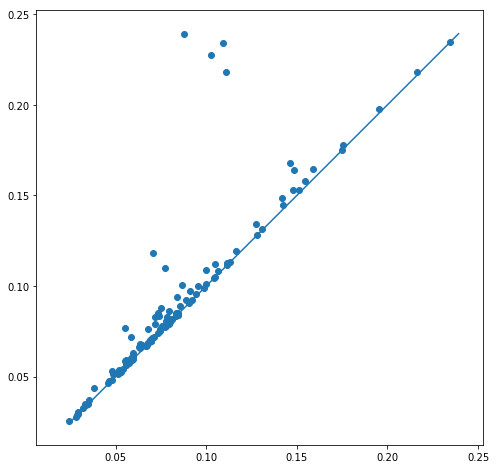

In [18]:
plot_diagram(critical_edges)

In [19]:
def widest_gap(edges):
    # create a new class that records the span of a persistent point and
    # keeps track of which edge in the original diagram it corresponds
    PersistencePoint = collections.namedtuple('PersistencePoint', 'ind birth death span')
    pers = [PersistencePoint(i, p.birth, p.death, p.death-p.birth) 
                   for i,p in enumerate(edges)]
    # sort the points by span
    pers = sorted(pers, key=attrgetter('span'))
    
    # create an array with the gaps between points
    diagonals = [(pers[i].span-pers[i-1].span, i) for i in range(1,len(pers))]
    # sort this array by in descending order
    diagonals.sort(reverse=True)
    
    # get all edges that have a span greater than the widest gap
    critical_edges = [edges[p.ind] for p in pers[diagonals[0][1]:]]
    
    return critical_edges

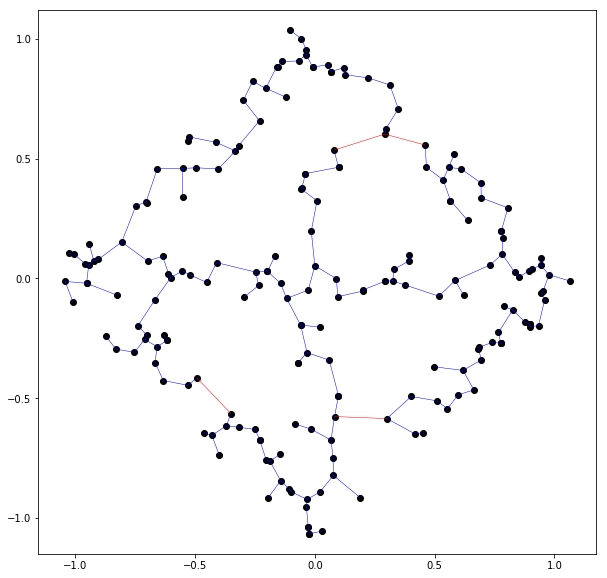

In [20]:
stable_edges = widest_gap(critical_edges)
draw_hopes(subcloud, mst, stable_edges)

The 4 red critical edges from the derived HoPeS in the above picture together with the blue $MST(C)$ now produce a skeleton with exactly 4 independent cycles (a homotopically correct reconstruction) as expected from a noisy sample of the wheel graph. See the examples of the derived HoPeS for random noisy samples of more complicated graphs further down.

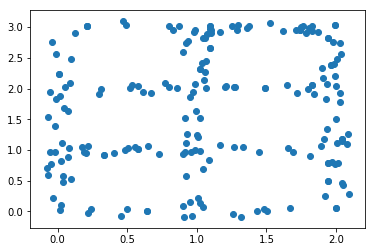

In [21]:
grid = np.genfromtxt('data/grid.txt', delimiter=' ')
plt.scatter(grid[random_indices,0], grid[random_indices,1])
plt.show()

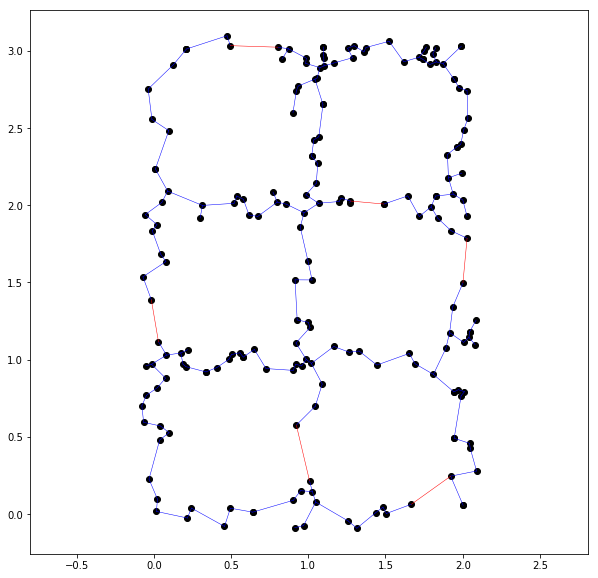

In [22]:
mst, critical_edges = HoPeS(grid[random_indices,])
stable_edges = widest_gap(critical_edges)
draw_hopes(grid[random_indices,], mst, stable_edges)

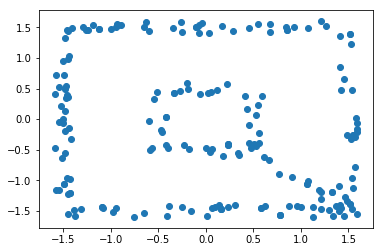

In [23]:
squares = np.genfromtxt('data/squares.txt', delimiter=' ')
plt.scatter(squares[random_indices,0], squares[random_indices,1])
plt.show()

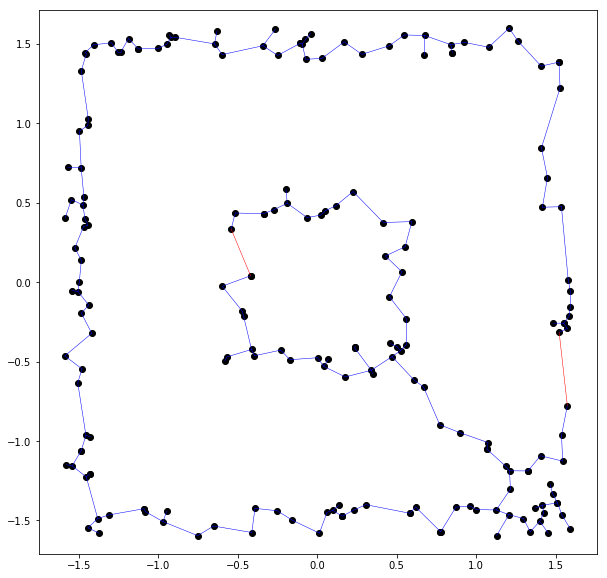

In [24]:
mst, critical_edges = HoPeS(squares[random_indices,])
stable_edges = widest_gap(critical_edges)
draw_hopes(squares[random_indices,], mst, stable_edges)

Theoretical guarantees for reconstructing graphs from noisy samples were proved in a general form by the same <a href="http://kurlin.org/research-papers.php#CGF2015">CGF paper</a> (Computer Graphics Forum, 2015). See also results on real data in the application to image skeletonization in the <a href="http://kurlin.org/research-papers.php#CAIP2015">CAIP paper</a> (Computer Analysis of Images and Patterns, 2015). More specific and explicit guarantees for 2D clouds were obtained in the <a href="http://kurlin.org/research-papers.php#PRL2016">PRL paper</a> (Pattern Recognition Letters, 2016). 

Thank you for completing this tutorial! Your comments and feedback are welcome at vitaliy.kurlin@gmail.com.